## Population Density

C:\Users\Work\AppData\Local\Temp\ipykernel_8960\3509588049.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy



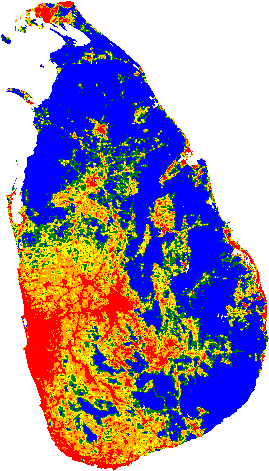
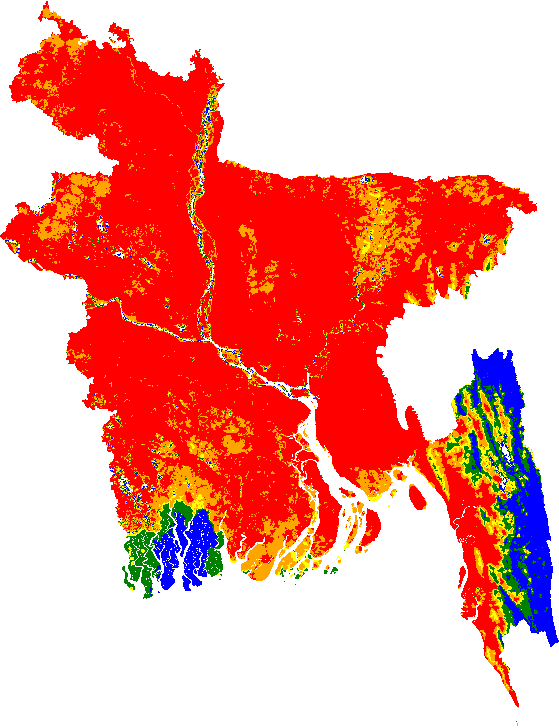
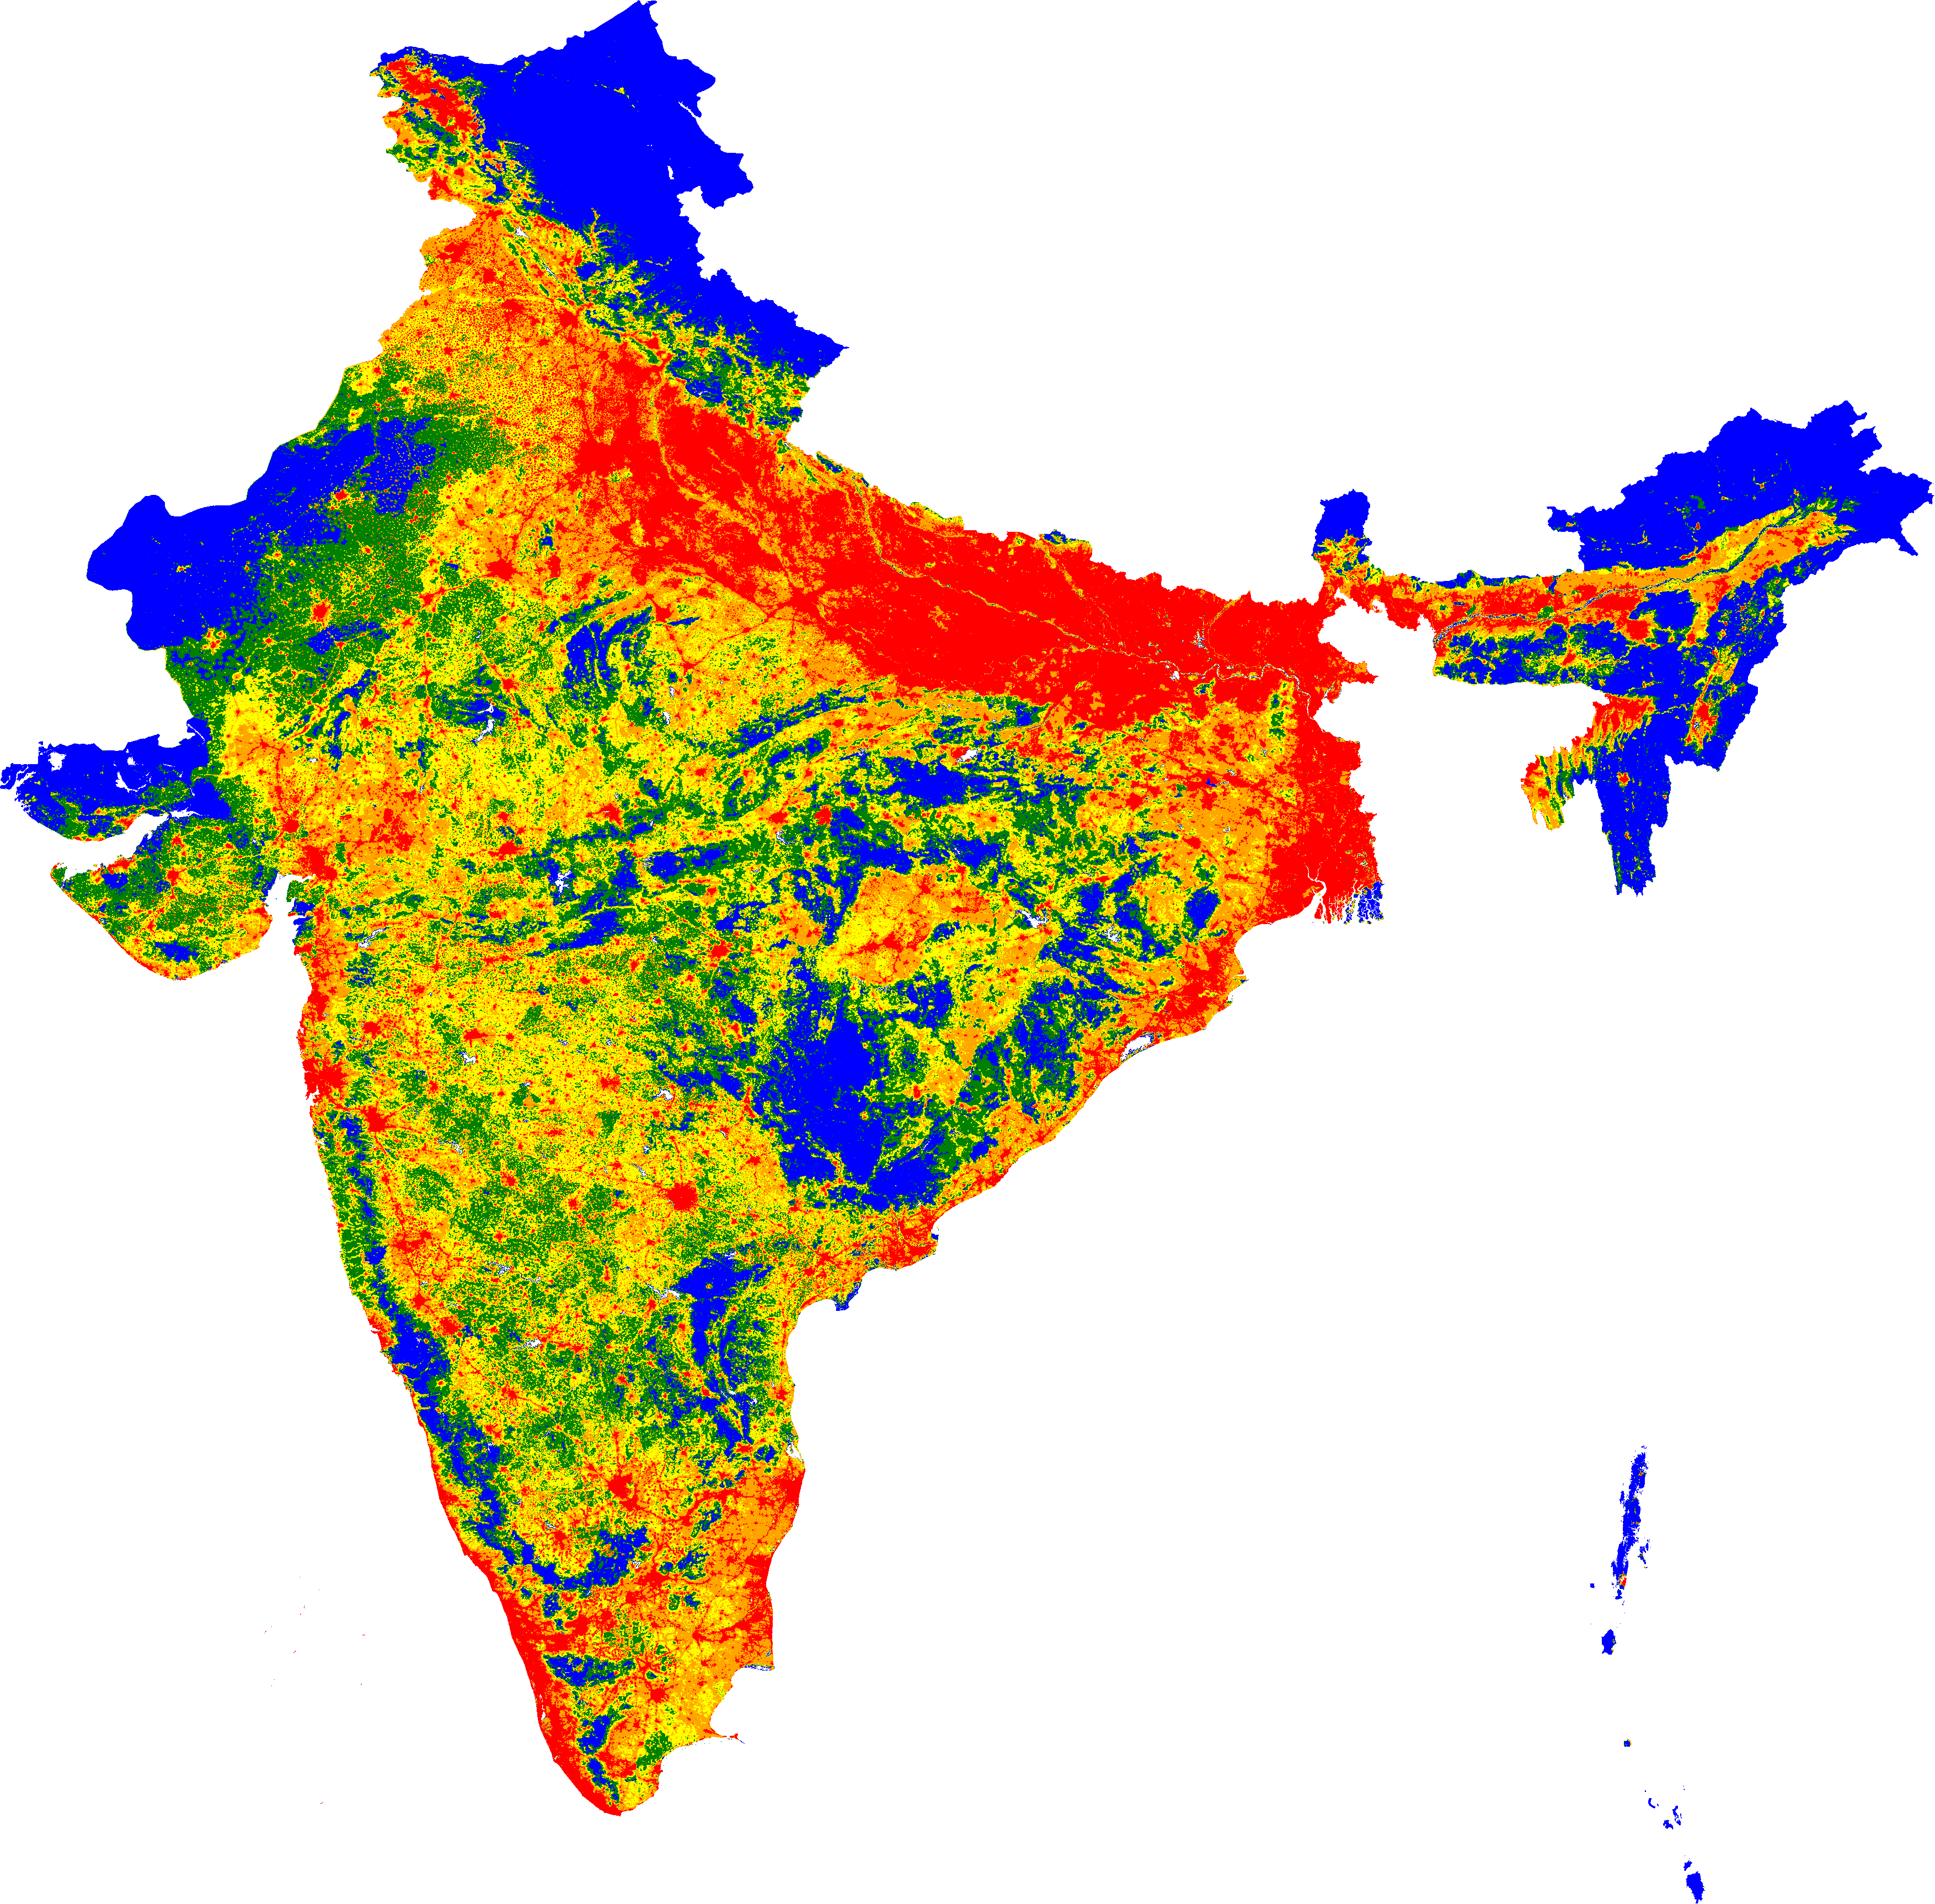

In [5]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import mask
import numpy as np
import shapely as shp
import folium
import branca.colormap as bcm

lka_admin0_shpfile_path = "../_data/raw/lka_adm/lka_admbnda_adm0_slsd_20220816.shp"
lka_pop_density_path = "../_data/raw/lka_pd_2020_1km.tif"
bgd_admin0_shpfile_path = "../_data/raw/bgd_adm/bgd_admbnda_adm0_bbs_20201113.shp"
bgd_pop_density_path = "../_data/raw/bgd_pd_2020_1km.tif"
ind_admin0_shpfile_path = "../_data/raw/ind_adm/adm0.shp"
ind_pop_density_path = "../_data/raw/ind_pd_2020_1km.tif"

lka_admin_raw = gpd.read_file(lka_admin0_shpfile_path)
lka_density_raw = rio.open(lka_pop_density_path)
lka_bounding_box = lka_density_raw.bounds
lka_bounds = [[lka_bounding_box.bottom, lka_bounding_box.left], [lka_bounding_box.top, lka_bounding_box.right]]
lka_image, lka_transform = mask.mask(lka_density_raw, list(lka_admin_raw["geometry"][0].geoms), nodata = np.nan)
lka_image = lka_image[0]

bgd_admin_raw = gpd.read_file(bgd_admin0_shpfile_path)
bgd_density_raw = rio.open(bgd_pop_density_path)
bgd_bounding_box = bgd_density_raw.bounds
bgd_bounds = [[bgd_bounding_box.bottom, bgd_bounding_box.left], [bgd_bounding_box.top, bgd_bounding_box.right]]
bgd_image, bgd_transform = mask.mask(bgd_density_raw, list(bgd_admin_raw["geometry"][0].geoms), nodata = np.nan)
bgd_image = bgd_image[0]

ind_admin_raw = gpd.read_file(ind_admin0_shpfile_path)
ind_density_raw = rio.open(ind_pop_density_path)
ind_bounding_box = ind_density_raw.bounds
ind_bounds = [[ind_bounding_box.bottom - .08, ind_bounding_box.left], [ind_bounding_box.top - 0.35, ind_bounding_box.right]]
ind_image, ind_transform = mask.mask(ind_density_raw, list(ind_admin_raw["geometry"][0].geoms), nodata = np.nan)
ind_image = ind_image[0]

# ind_image = ind_density_raw.read(1)
# ind_image[ind_image < 0] = np.nan
all_shape = pd.concat((ind_admin_raw, bgd_admin_raw, lka_admin_raw))
all_shape["all"] = 1
all_shape = all_shape[["all", "geometry"]].dissolve(by = "all").reset_index()
centroid_lon, centroid_lat = all_shape.centroid[0].coords.xy
centroid_lon, centroid_lat = centroid_lon[0], centroid_lat[0]

all_density = np.log(np.hstack((lka_image.ravel(), bgd_image.ravel(), ind_image.ravel())) + 0.003)
density_bins = np.percentile(all_density[np.logical_not(np.isnan(all_density))], q = [20, 40, 60, 80, 100])
lka_image_bins = np.digitize(np.log(lka_image + 0.003), density_bins).astype(float)
lka_image_bins[lka_image_bins == 5] = np.nan
bgd_image_bins = np.digitize(np.log(bgd_image + 0.003), density_bins).astype(float)
bgd_image_bins[bgd_image_bins == 5] = np.nan
ind_image_bins = np.digitize(np.log(ind_image + 0.003), density_bins).astype(float)
ind_image_bins[ind_image_bins == 5] = np.nan

step = bcm.StepColormap(
    ["blue", "green", "yellow", "orange", "red", (0, 0, 0, 0)], vmin=0, vmax=100, index=[0, 20, 40, 60, 80, 100], caption = "Percentile for Population Density by $Km^2$"
)

m = folium.Map(location=(centroid_lat, centroid_lon), zoom_start = 5)
lka_group = folium.FeatureGroup("Sri Lanka").add_to(m)
folium.raster_layers.ImageOverlay(lka_image_bins * 20, opacity = .5, bounds = lka_bounds, colormap=step).add_to(lka_group)
bgd_group = folium.FeatureGroup("Bangladesh").add_to(m)
folium.raster_layers.ImageOverlay(bgd_image_bins * 20, opacity = .5, bounds = bgd_bounds, colormap=step).add_to(bgd_group)
ind_group = folium.FeatureGroup("India").add_to(m)
folium.raster_layers.ImageOverlay(ind_image_bins * 20, opacity = .5, bounds = ind_bounds, colormap=step).add_to(ind_group)
step.add_to(m)
folium.LayerControl().add_to(m)
m